In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import glob
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
from patsy import dmatrices
from math import sqrt
sns.set_style('white')

In [2]:
filename_2019 = glob.glob('../data/2019/*.csv')
filename_2019.sort()
filename_2019

['../data/2019/agm.csv',
 '../data/2019/alm.csv',
 '../data/2019/bum.csv',
 '../data/2019/cfm.csv',
 '../data/2019/cum.csv',
 '../data/2019/ebm.csv',
 '../data/2019/egm.csv',
 '../data/2019/hcm.csv',
 '../data/2019/im.csv',
 '../data/2019/jm.csv',
 '../data/2019/jmm.csv',
 '../data/2019/lm.csv',
 '../data/2019/mam.csv',
 '../data/2019/nim.csv',
 '../data/2019/oim.csv',
 '../data/2019/pbm.csv',
 '../data/2019/ppm.csv',
 '../data/2019/rbm.csv',
 '../data/2019/rum.csv',
 '../data/2019/smm.csv',
 '../data/2019/snm.csv',
 '../data/2019/srm.csv',
 '../data/2019/tam.csv',
 '../data/2019/vm.csv',
 '../data/2019/znm.csv']

In [3]:
df = pd.read_csv(filename_2019[0], index_col=0, encoding='gbk')
df.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open interest']
df.rename_axis("type", axis='index', inplace=True)
df['time'] = pd.to_datetime(df['time'])

df.reset_index(inplace=True)
df

,type,code,time,open,high,low,close,volume,turnover,open interest
0,SC,ag1906,2019-01-02 09:01:00,3700.0,3700.0,3689.0,3693.0,16680.0,924595320.0,704740
1,SC,ag1906,2019-01-02 09:02:00,3693.0,3695.0,3693.0,3694.0,5184.0,287231490.0,704034
2,SC,ag1906,2019-01-02 09:03:00,3693.0,3694.0,3688.0,3690.0,5782.0,320071080.0,703846
3,SC,ag1906,2019-01-02 09:04:00,3690.0,3692.0,3689.0,3692.0,3100.0,171616620.0,703254
4,SC,ag1906,2019-01-02 09:05:00,3691.0,3693.0,3691.0,3692.0,2184.0,120945390.0,702870
...,...,...,...,...,...,...,...,...,...,...
133105,SC,ag2002,2019-12-31 14:56:00,4385.0,4386.0,4384.0,4385.0,4026.0,264795480.0,392150
133106,SC,ag2002,2019-12-31 14:57:00,4385.0,4386.0,4383.0,4384.0,4526.0,297656190.0,391580
133107,SC,ag2002,2019-12-31 14:58:00,4384.0,4387.0,4383.0,4387.0,5064.0,333129450.0,390390
133108,SC,ag2002,2019-12-31 14:59:00,4388.0,4388.0,4386.0,4386.0,3570.0,234917340.0,389040


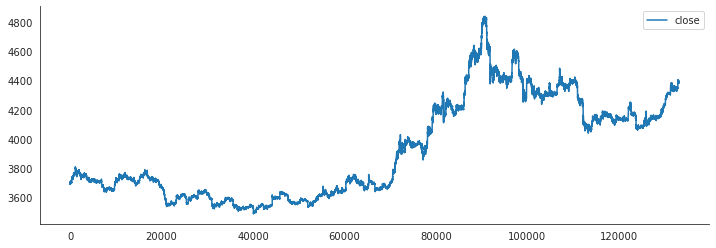

In [4]:
df[['close']].plot(grid=False, figsize=(12,4))
sns.despine()

In [5]:
df['one_minute_return'] = df['close'].shift(-1) - df['close']
df['five_minute_return'] = df['close'].shift(-5) - df['close']
df['fifteen_minute_return'] = df['close'].shift(-15) - df['close']
df['thirty_minute_return'] = df['close'].shift(-30) - df['close']
df['hour_return'] = df['close'].shift(-60) - df['close']

In [6]:
times = ['one_minute_return','five_minute_return', 'fifteen_minute_return', 'thirty_minute_return', 'hour_return']

In [7]:
# Drop NaN
df.drop(df.tail(60).index,inplace=True) 

In [8]:
df['one_minute_return']

0         1.0
1        -4.0
2         2.0
3         0.0
4         3.0
         ... 
133045    0.0
133046    1.0
133047    1.0
133048    1.0
133049    2.0
Name: one_minute_return, Length: 133050, dtype: float64

In [9]:
short_period = [2, 4, 8, 16, 32, 64]
long_period = [8, 16, 32, 64, 128, 256]

df['short_ewm'] = df['close'].ewm(span=short_period[2]).mean()
df['long_ewm'] = df['close'].ewm(span=long_period[2]).mean()

In [10]:
def calculate_hull_moving_average(df, period):

    df['window_t_ewm'] = df['close'].ewm(span=period).mean()
    df['window_half_ewm'] = df['close'].ewm(span=period/2).mean()
    df['diff']=df['window_half_ewm'] * 2 - df['window_t_ewm']
    
    df[f'hma{period}']=df['diff'].ewm(span=int(math.sqrt(period))).mean()
    
    irrelevant_col = ['window_t_ewm', 'window_half_ewm', 'diff']
    df.drop(columns=irrelevant_col, inplace = True)
    
calculate_hull_moving_average(df, short_period[2])
calculate_hull_moving_average(df, long_period[2])

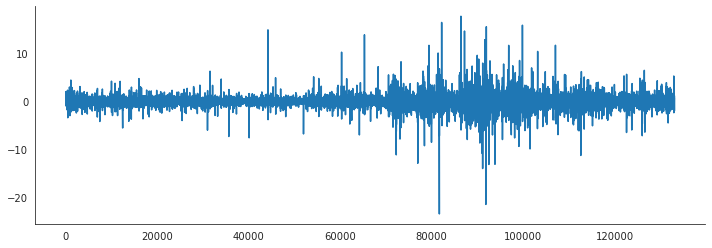

In [11]:
df['short_long_diff'] = df[f'hma{short_period[2]}'] - df[f'hma{long_period[2]}']

short_long_diff_std = df['short_long_diff'].std()

df['momentum'] = df['short_long_diff'] / short_long_diff_std

df['momentum'].plot(grid=False, figsize=(12,4))
sns.despine()

In [12]:
X2 = sm.add_constant(df['momentum'])
est = sm.OLS(df['one_minute_return'], X2, missing='drop')
results = est.fit()
print(results.summary())
print("Parameters: ", results.params['momentum'])
print("P Values: ", results.pvalues)

                            OLS Regression Results                            
Dep. Variable:      one_minute_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     71.02
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           3.56e-17
Time:                        00:15:38   Log-Likelihood:            -2.8077e+05
No. Observations:              133050   AIC:                         5.615e+05
Df Residuals:                  133048   BIC:                         5.616e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.005      0.982      0.3

In [13]:
threshold = [0, 0.1, 0.25, 0.5, 0.75, 1, 2]

In [14]:
def calculate_future_return(data):
    data['one_minute_return'] = data['close'].shift(-1) - data['close']
    data['five_minute_return'] = data['close'].shift(-5) - data['close']
    data['fifteen_minute_return'] = data['close'].shift(-15) - data['close']
    data['thirty_minute_return'] = data['close'].shift(-30) - data['close']
    data['hour_return'] = data['close'].shift(-60) - data['close']
    # Drop NaN
    df.drop(df.tail(60).index,inplace=True) 

In [15]:
def calculate_momentum(data, short_period, long_period, hma=True):
    if (hma):
        calculate_hull_moving_average(data, short_period)
        calculate_hull_moving_average(data, long_period)
        data['short_long_diff'] = data[f'hma{short_period}'] - data[f'hma{long_period}']
        short_long_diff_std = data['short_long_diff'].std()
        data['momentum'] = data['short_long_diff'] / short_long_diff_std
        
        used_col = ['short_long_diff', f'hma{short_period}', f'hma{long_period}']
        data.drop(columns=used_col, inplace = True)
        
    else:
        data['short_ewm'] = data['close'].ewm(span=short_period).mean()
        data['long_ewm'] = data['close'].ewm(span=long_period).mean()
        data['short_long_diff'] = data['short_ewm'] - data['long_ewm']
        short_long_diff_std = data['short_long_diff'].std()
        data['momentum'] = data['short_long_diff'] / short_long_diff_std
        
        used_col = ['short_long_diff', data['short_ewm'], data['short_ewm']]
        data.drop(columns=used_col, inplace = True)

In [16]:
def linear_regression_parameters_of_momentum(data, time = 'one_minute_return'):
    X2 = sm.add_constant(data['momentum'])
    est = sm.OLS(data[time], X2, missing='drop')
    results = est.fit()
    # print(results.summary())
    parameter = results.params['momentum']
    r_square = results.rsquared
    
    return parameter, r_square

沪银主力（AGM），表格Index为均线Window长度（short-long），Column为Return Time Window

In [17]:
# print(filename_2019[1])
# data = pd.read_csv(filename_2019[1], index_col=0, encoding='gbk')
data = pd.read_csv('../data/2019/agm.csv', index_col=0, encoding='gbk')

data.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open interest']
data.rename_axis("type", axis='index', inplace=True)
data['time'] = pd.to_datetime(data['time'])

data.reset_index(inplace=True)
calculate_future_return(data)

In [18]:
parameters = []
r_squares = []
for i in range(len(short_period)):
    calculate_momentum(data, short_period[i], long_period[i])
    current_window_parameter = []
    current_window_r_square = []
    for j in range(len(times)):
        parameter, r_square = linear_regression_parameters_of_momentum(data, times[j])
        current_window_parameter.append(parameter)
        current_window_r_square.append(r_square)
    parameters.append(current_window_parameter)
    r_squares.append(current_window_r_square)

In [19]:
# parameters
window_index = ['2-8','4-16','8-32','16-64', '32-128', '64-256']
parameters_df = pd.DataFrame.from_records(parameters, index = window_index)
parameters_df.columns = times
print('Regression Parameter')
parameters_df

Regression Parameter


,one_minute_return,five_minute_return,fifteen_minute_return,thirty_minute_return,hour_return
2-8,-0.146502,-0.198486,-0.174845,-0.138212,-0.117708
4-16,-0.087612,-0.158230,-0.022421,-0.013569,0.086422
8-32,-0.046150,-0.061072,0.156977,0.231215,0.312633
16-64,0.002276,0.077015,0.313075,0.454587,0.385801
32-128,0.016440,0.100891,0.263423,0.330722,0.152290
64-256,0.009825,0.048245,0.088226,0.039146,-0.171415


In [20]:
maxp_return_window = parameters_df.max().idxmax()
maxp_ma_window = parameters_df.idxmax()[maxp_return_window]
print("Max parameter ma window:", maxp_ma_window, "\nMax parameter return window:", maxp_return_window)

Max parameter ma window: 16-64 
Max parameter return window: thirty_minute_return


In [21]:
# r_squares
r_squares_df = pd.DataFrame.from_records(r_squares, index = ['2-8','4-16','8-32','16-64', '32-128', '64-256'])
r_squares_df.columns = times
# print('R-Squared')
# r_squares_df

In [22]:
window_index_to_window = {'2-8':[2, 8],
                          '4-16':[4, 16],
                          '8-32':[8, 32],
                          '16-64':[16, 64],
                          '32-128':[32, 128],
                          '64-256':[64, 256]}

In [23]:
# Residule plot for 16-64 with thirty minute return
short_ma_period = window_index_to_window[maxp_ma_window][0]
long_ma_period = window_index_to_window[maxp_ma_window][1]
calculate_momentum(data, short_ma_period, long_ma_period)
X2 = sm.add_constant(data['momentum'])
est = sm.OLS(data[maxp_return_window], X2, missing='drop')

results = est.fit()

parameter = results.params['momentum']
r_square = results.rsquared
print(parameter, r_square)

0.4545869388420349 0.0019912496554473913


Residule plot for 16-64 momentum predicting thirty_minute_return


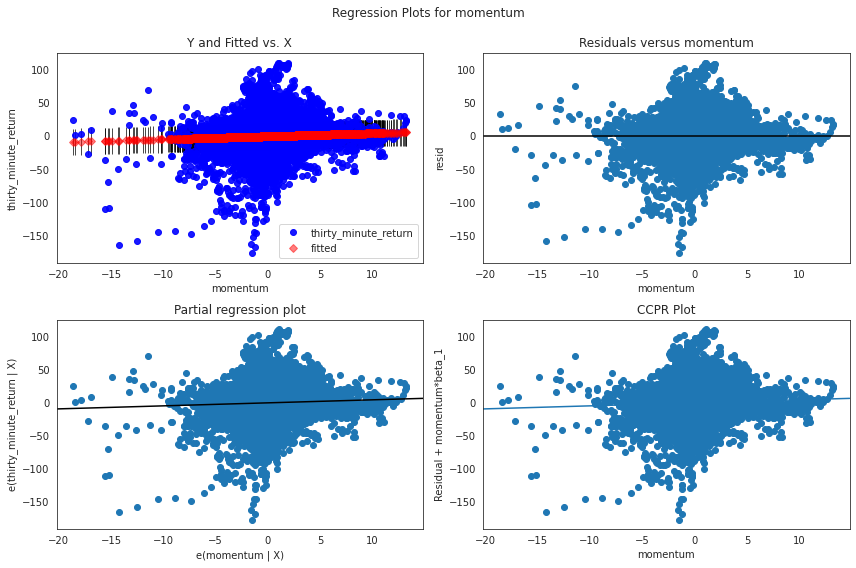

In [24]:
#define figure size
print("Residule plot for {ma_window} momentum predicting {return_window}".format(ma_window = maxp_ma_window, return_window = maxp_return_window))
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(results, 'momentum', fig=fig)

Reference: https://towardsdatascience.com/heteroscedasticity-is-nothing-to-be-afraid-of-730dd3f7ca1f

In [25]:
expr = maxp_return_window + ' ~ momentum'
y, X = dmatrices(expr, data, return_type='dataframe')

In [26]:
keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results = het_white(results.resid, X)
lzip(keys, results)

[('Lagrange Multiplier statistic:', 2991.20287713067),
 ("LM test's p-value:", 0.0),
 ('F-statistic:', 1529.9561302882537),
 ("F-test's p-value:", 0.0)]

In [27]:
for filename in filename_2019:
    print(filename)
    data = pd.read_csv(filename, index_col=0, encoding='gbk')

    data.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open interest']
    data.rename_axis("type", axis='index', inplace=True)
    data['time'] = pd.to_datetime(data['time'])

    data.reset_index(inplace=True)
    calculate_future_return(data)
    
    parameters = []
    r_squares = []
    for i in range(len(short_period)):
        calculate_momentum(data, short_period[i], long_period[i])
        current_window_parameter = []
        current_window_r_square = []
        for j in range(len(times)):
            parameter, r_square = linear_regression_parameters_of_momentum(data, times[j])
            current_window_parameter.append(parameter)
            current_window_r_square.append(r_square)
        parameters.append(current_window_parameter)
        r_squares.append(current_window_r_square)
    
    # parameters
    window_index = ['2-8','4-16','8-32','16-64', '32-128', '64-256']
    parameters_df = pd.DataFrame.from_records(parameters, index = window_index)
    parameters_df.columns = times
    
    max_return_window = parameters_df.max().idxmax()
    max_ma_window = parameters_df.idxmax()[max_return_window]
    print("Max ma window:", max_ma_window, "\nMax return window:", max_return_window)
    
    # Residule plot for 16-64 with thirty minute return
    short_ma_period = window_index_to_window[maxp_ma_window][0]
    long_ma_period = window_index_to_window[maxp_ma_window][1]
    calculate_momentum(data, short_ma_period, long_ma_period)
    X2 = sm.add_constant(data['momentum'])
    est = sm.OLS(data[maxp_return_window], X2, missing='drop')

    results = est.fit()

    parameter = results.params['momentum']
    r_square = results.rsquared
    # print(parameter, r_square)
    
    expr = maxp_return_window + ' ~ momentum'
    y, X = dmatrices(expr, data, return_type='dataframe')
    
    keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
    results = het_white(results.resid, X)
    print(lzip(keys, results))

../data/2019/agm.csv
Max ma window: 16-64 
Max return window: thirty_minute_return
[('Lagrange Multiplier statistic:', 2991.20287713067), ("LM test's p-value:", 0.0), ('F-statistic:', 1529.9561302882537), ("F-test's p-value:", 0.0)]
../data/2019/alm.csv
Max ma window: 64-256 
Max return window: one_minute_return
[('Lagrange Multiplier statistic:', 1334.1773789477513), ("LM test's p-value:", 1.9367038746550883e-290), ('F-statistic:', 675.1311362183706), ("F-test's p-value:", 3.560936761169545e-292)]
../data/2019/bum.csv
Max ma window: 32-128 
Max return window: hour_return
[('Lagrange Multiplier statistic:', 11.834645193486006), ("LM test's p-value:", 0.0026923991736614084), ('F-statistic:', 5.917950190947399), ("F-test's p-value:", 0.0026918412707350545)]
../data/2019/cfm.csv
Max ma window: 64-256 
Max return window: hour_return
[('Lagrange Multiplier statistic:', 7.521979807882939), ("LM test's p-value:", 0.02326070311274725), ('F-statistic:', 3.761178887739717), ("F-test's p-value:",